# Load Data

In [1]:
#!pip install pandas_datareader
import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

import itertools

In [3]:
data = pd.read_excel("./변환.xlsx")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data.tail()

,price
date,
2021-10-01,114.1
2021-11-01,115.9
2021-12-01,116.7
2022-01-01,116.8
2022-02-01,116.6


# ARIMA Procedure

## Data Preprocessing

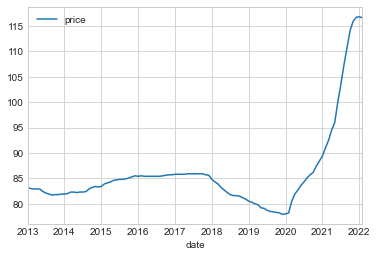

In [11]:
# Raw data plot
fig = data.plot()

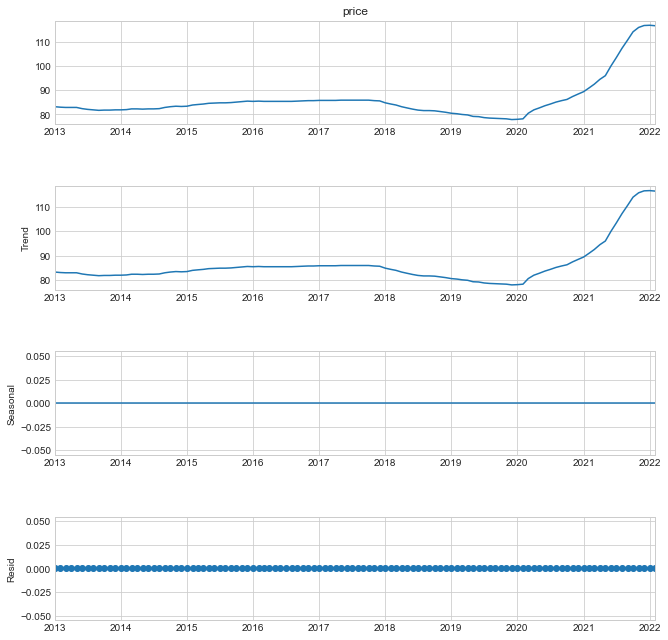

In [12]:
# Seasonal decompose
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

decompostion = sm.tsa.seasonal_decompose(data['price'], model='additive', period=1)
fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

# 1.Observed : observed data
# 2.Trend : The estimated trend component
# 3.Seasonal : The estimate seasonal component
# 4.resid : The estimate residuals

## Identify Model to be Tentatively Entertainted

In [13]:
# Train:Test = 7:3
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)

C:\Users\andam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


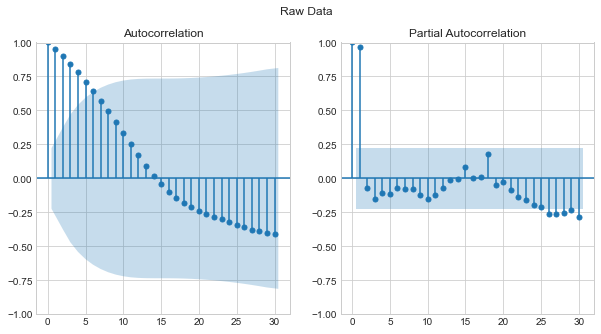

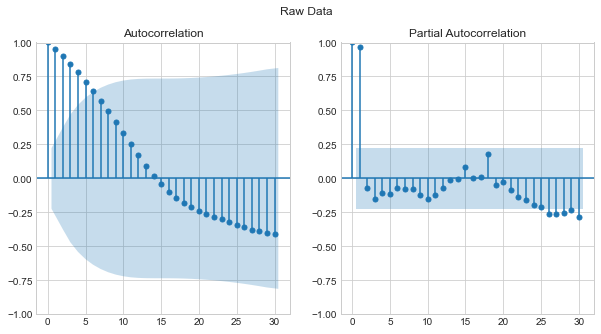

In [14]:
# ACF, PACF plot

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])

# ACF 
# PACF

## Differencing

In [586]:
# Differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['price'].diff()
diff_train_data = diff_train_data.dropna()
print('##### Raw Data #####')
print(train_data)
print('##### Differenced Data #####')
print(diff_train_data)

##### Raw Data #####
            price
date             
2013-01-01   83.2
2013-02-01   83.0
2013-03-01   82.9
2013-04-01   82.9
2013-05-01   82.9
...           ...
2019-01-01   80.5
2019-02-01   80.3
2019-03-01   80.0
2019-04-01   79.8
2019-05-01   79.2

[77 rows x 1 columns]
##### Differenced Data #####
date
2013-02-01   -0.2
2013-03-01   -0.1
2013-04-01    0.0
2013-05-01    0.0
2013-06-01   -0.5
             ... 
2019-01-01   -0.4
2019-02-01   -0.2
2019-03-01   -0.3
2019-04-01   -0.2
2019-05-01   -0.6
Name: price, Length: 76, dtype: float64


NameError: name 'diff_train_data' is not defined

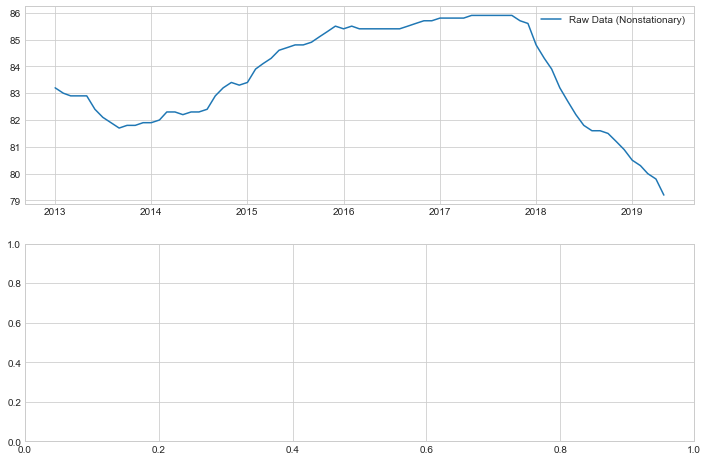

In [8]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['price'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange') #first difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

C:\Users\andam\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


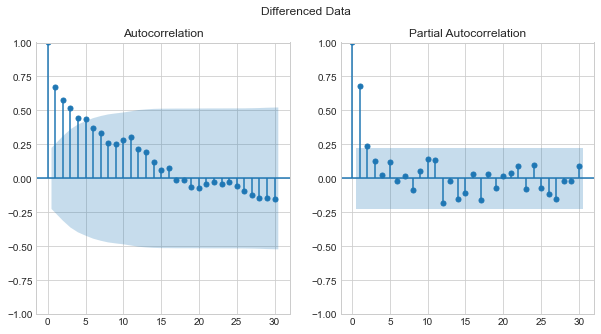

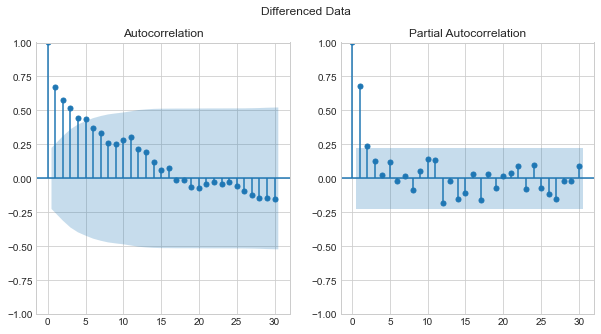

In [588]:
# ACF, PACF plot

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

## Estimate Parameters

In [589]:
index_new = pd.date_range('2019-06-01','2022-03-01',freq='MS', closed='left')
index_new.shape

C:\Users\andam\AppData\Local\Temp\ipykernel_1320\3987095698.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  index_new = pd.date_range('2019-06-01','2022-03-01',freq='MS', closed='left')


(33,)

In [590]:
# ARIMA model fitting
# The (p, d, q) order of the model for the number of AR parameters, differences, and MA parameters to use.

model = sm.tsa.arima.ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   77
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  23.038
Date:                Fri, 13 May 2022   AIC                            -42.076
Time:                        16:33:09   BIC                            -37.414
Sample:                             0   HQIC                           -40.213
                                 - 77                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7299      0.119      6.135      0.000       0.497       0.963
sigma2         0.0316      0.003      9.298      0.000       0.025       0.038
===================================================================================
Ljung-Box (L1) (Q):                   2.00   Jarque-Bera (JB):                47.69
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.97
Prob(H) (two-sided):                  0.71   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [591]:
forecast = model_fit.forecast(len(test_data))
forecast = pd.Series(forecast, index=index_new)

<AxesSubplot:title={'center':'suwon'}, xlabel='date', ylabel='price'>

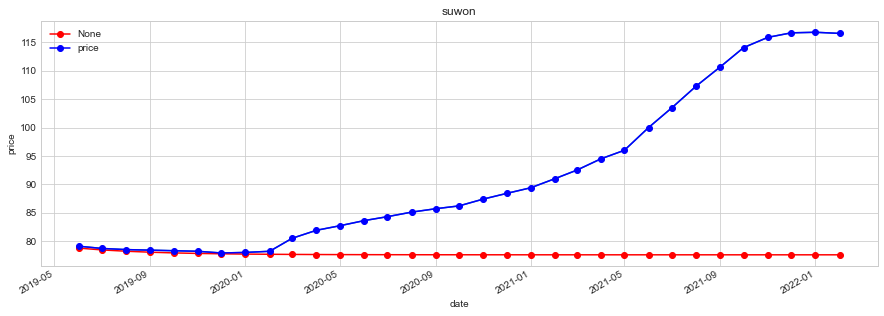

In [592]:
fig,ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='date', y='price', data=test_data)
chart.set_title('suwon')
forecast.plot(ax=ax, color='red', marker='o', legend=True)
test_data.plot(ax=ax, color='blue', marker='o', legend=True)

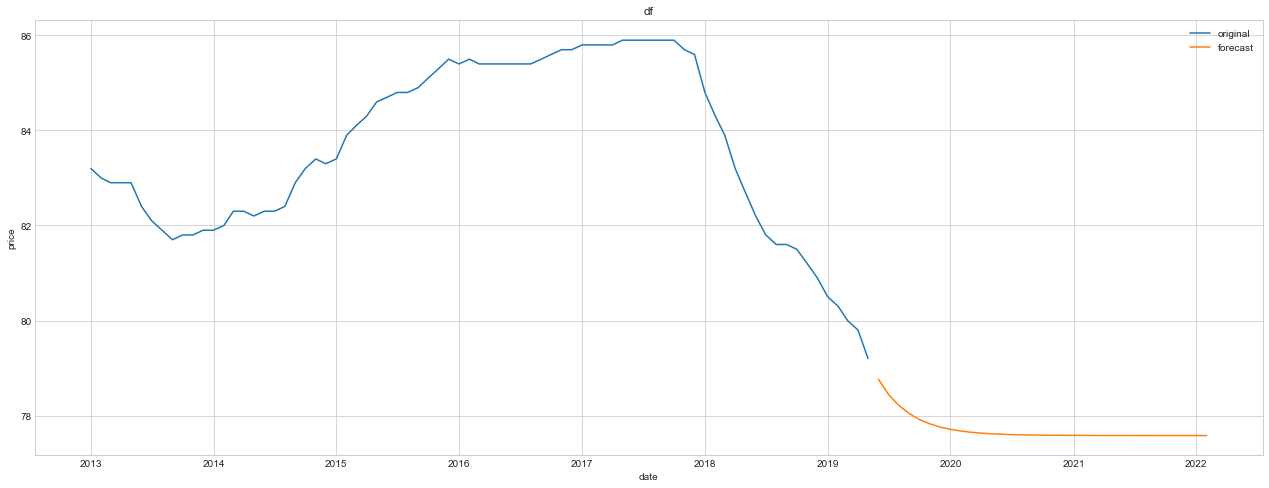

In [593]:
plt.figure(figsize=(22,8))
plt.plot(train_data, label='original')
plt.plot(forecast,label='forecast')
plt.title('df')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.show()

## Diagnosis Check - ARIMA

In [594]:
# Parameter search

print('Examples of parameter combinations for Seasonal AIRMA...')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))

aic=[]
for i in pdq:
    model = sm.tsa.arima.ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

Examples of parameter combinations for Seasonal AIRMA...
ARIMA: (0, 1, 0) >> AIC : 8.39
ARIMA: (0, 1, 1) >> AIC : -20.66
ARIMA: (0, 1, 2) >> AIC : -27.59
ARIMA: (1, 1, 0) >> AIC : -42.08
ARIMA: (1, 1, 1) >> AIC : -45.24
ARIMA: (1, 1, 2) >> AIC : -43.68
ARIMA: (2, 1, 0) >> AIC : -43.8
ARIMA: (2, 1, 1) >> AIC : -43.74
ARIMA: (2, 1, 2) >> AIC : -43.56


C:\Users\andam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\andam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [595]:
# Search optimal parameters (가장 낮은 AIC값을 갖는 parameter 선정)

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((1, 1, 1), -45.24)]

In [596]:
model_opt = sm.tsa.arima.ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   77
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  25.619
Date:                Fri, 13 May 2022   AIC                            -45.237
Time:                        16:33:10   BIC                            -38.245
Sample:                             0   HQIC                           -42.443
                                 - 77                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9039      0.073     12.339      0.000       0.760       1.047
ma.L1         -0.4056      0.216     -1.874      0.061      -0.830       0.019
sigma2         0.0295      0.003      9.810      0.000       0.024       0.035
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                52.77
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.84
Prob(H) (two-sided):                  0.94   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [597]:
forecast.shape

(33,)

## use Model to Forecast - ARIMA

In [598]:
prediction = model_opt_fit.forecast(len(test_data))
prediction

array([78.82149546, 78.47937   , 78.17012715, 77.89060645, 77.63795125,
       77.40957941, 77.203157  , 77.01657441, 76.84792477, 76.6954845 ,
       76.55769567, 76.4331501 , 76.32057494, 76.21881968, 76.12684439,
       76.0437091 , 75.96856416, 75.9006416 , 75.83924727, 75.7837537 ,
       75.73359378, 75.68825485, 75.64727358, 75.61023112, 75.57674892,
       75.54648478, 75.5191294 , 75.49440323, 75.47205355, 75.45185197,
       75.43359201, 75.41708706, 75.40216845])

In [599]:
df = pd.DataFrame(prediction)
df.to_excel('예측값.xlsx')